<ipython-input-5-1ba5b51f2985>:284: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


<Figure size 1296x360 with 0 Axes>

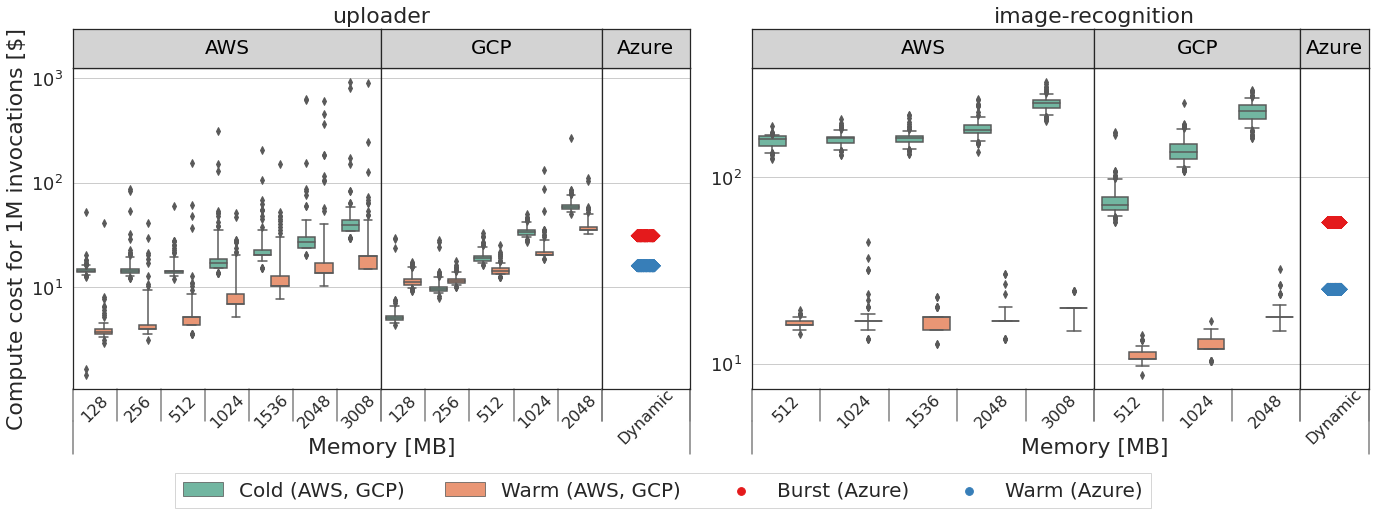

In [5]:
%matplotlib inline

import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
from itertools import groupby
plt.rcParams['pdf.fonttype'] = 42

sns.set(rc={'figure.figsize':(18, 5)})
sns.set(style="ticks")
sns.set_style("white")                                                                              
plt.rcParams["axes.grid"] = True                                                                    
plt.rcParams['axes.xmargin'] = 0

plt.clf()

from matplotlib import gridspec

axs = []
f = plt.figure()

gs0 = gridspec.GridSpec(1, 2, figure=f,hspace=0.35, wspace=0.1)

dirs = ['120', '411',]
names = ['uploader',#\nUpload downloaded zip package to storage',
         'image-recognition'#\npytorch ResNet-50 inference',
        ]
SAMPLES = 200

def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

def add_line(ax, xpos, ypos,h=.1):
    line = plt.Line2D([xpos, xpos], [ypos + h, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df, rpositions):
    ypos = -.1
    scale = 1./df.index.get_level_values(0).nunique()#df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        for label, rpos in label_len(df.index,level):
            #rpos = 1600
            rpos=1
            lxpos = (pos + .5 * rpos)*scale

            # lower for a longer text
            ypos_offset = 0
            if len(str(label)) > 6:
                ypos_offset = -.07
            elif len(str(label)) >= 4:
                ypos_offset = -.02
            ax.text(lxpos, ypos + ypos_offset, label, ha='center', transform=ax.transAxes, fontsize=16,rotation=45)
            # but line always of the same height
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

def cost_processing_aws(benchmark: str, group_name, df):
    # "The monthly compute price is $0.00001667 per GB-s and the free tier provides 400,000 GB-s.
    # The monthly request price is $0.20 per 1 million requests and the free tier provides 1M requests per month.""
    # microseconds -> miliseconds, roundup to 100 ms -> seconds
    time_seconds = (d['provider_time']/1000).apply(roundup) / 1000
    memory_gb = group_name[0]/1024.0
    # price for 1M invocations = 0.2
    return (time_seconds * memory_gb * 10**6 * 1.667 * 10**-5 + 0.2).rename('cost')

def cost_processing_gcp(benchmark: str, group_name, df):
    # https://cloud.google.com/functions/pricing
    # "The monthly compute price is $0.00001667 per GB-s and the free tier provides 400,000 GB-s.
    # The monthly request price is $0.20 per 1 million requests and the free tier provides 1M requests per month.""
    cpu_allocations = {
        128: 200,
        256: 400,
        512: 800,
        1024: 1400,
        2048: 2400,
        4096: 4800
    }
    time_seconds = (d['provider_time']/1000).apply(roundup) / 1000
    memory_gb = group_name[0]/1024.0
    ghz = cpu_allocations[group_name[0]] / 1000
    
    cost_memory = memory_gb * time_seconds * 2.5 * 10**-6
    cost_ghz = ghz * time_seconds * 10**-5
    
    # Invocations are charged at a per-unit rate of $0.0000004 per invocation,
    # excluding the first 2 million free invocations per month and are charged
    # regardless of the outcome of the function or its duration.
    return ((cost_memory + cost_ghz) * 10**6 + 0.4).rename('cost')

def cost_processing_azure(benchmark: str, group_name, df):
    
    # https://azure.microsoft.com/en-us/pricing/details/functions/
    # Azure - it's not given directly for each invocation, but we get a summary over 1 minute
    # read data coming from seperate query of azure bilings logs
    billing_df = pd.read_csv(os.path.join(
        os.path.pardir, os.path.pardir, os.path.pardir, "data", "performance",
        "azure_perf_cost", "cost_biling.csv"
    ))
    # get row
    x = billing_df.loc[(billing_df["benchmark"] == benchmark) & (billing_df["type"] == group_name[1])]
    count = x['exec_counts'].iloc[0]
    biling_data = x['exec_count_units_mbms_milions'].iloc[0]
    
    # Azure provides data in milions megabytes-miliseconds.
    # cost of milion gb-s - $16
    # divide by 1024 (gb) and 1000 (ms) -> milion gb-s
    biling_data_gbs = biling_data * 16 / 1000 / 1024
    # now divide by counts
    result = biling_data_gbs / count * 10**6
    
    # now cost for 1M invocs
    result += 0.2
    return pd.Series([result]).repeat(df.shape[0]).rename('cost')

for i in range(len(dirs)):

    dir = dirs[i]
    
    dataframes = []
    datapoints_per_plot = []
    for name, full_name, proc_func in [["aws", "AWS", cost_processing_aws],
                                       ["gcp", "GCP", cost_processing_gcp],
                                       ["azure", "Azure", cost_processing_azure]]:

        df = pd.read_csv(os.path.join(
            os.path.pardir, os.path.pardir, os.path.pardir, "data", "performance",
            f"{name}_perf_cost/{dir}/perf-cost/result.csv"
        ))
        # Remove accidental errors if not caught earlier
        df = df.drop(df[(df.type == 'warm') & (df.is_cold == True)].index)
        df = df.drop(df[(df.type == 'cold') & (df.is_cold == False)].index)
        # Remove cURL setup times (handshake, SSL, etc.) from client time
        df['client_time'] = df['client_time'] - df['connection_time'] * 1000*1000
        # GCP time is incorrectly in ms
        if name == 'gcp':
            df['provider_time'] = df['provider_time'].multiply(1000)
        # incorrect data for GCP NodeJS)
        df = df.drop(df[df.provider_time == 0].index)
        df = df.drop(df[df.exec_time == 0].index)

        # for each invocation type, take first SAMPLES invocations
        groups = []
        # on Azure, we have no memory configuration - just single configuration
        if df['memory'].iloc[0] == 0:
            df['memory'] = 'Dynamic'
            # drop seq data
            df.drop(df[df['type'] == 'sequential'].index, inplace=True)
            
        # remember the number of different configurations per provider
        datapoints_per_plot.append(df['memory'].nunique())
        df_grouped = df.groupby(['memory', 'type'])
        for group_name, df_group in df_grouped:
            # take first 200 samples
            d = df_group.head(SAMPLES)
            # add invocation cost for 1M invocations
            groups.append(pd.concat([d.reset_index(drop=True), proc_func(dir, group_name, d).reset_index(drop=True)],axis=1))
            
            
        df = pd.concat(groups)
        df.to_csv(f'{dirs[i]}_{name}.csv')
        # remove unnecessary data
        cols_to_drop = ['is_cold', 'client_time', 'connection_time', 'exec_time', 'provider_time']
        if 'mem_used' in df.columns:
            cols_to_drop.append('mem_used')
        # rename Azure warm to avoid confusion
        if name == 'azure':
            df.loc[df['type'] == 'warm', 'type'] = 'az_warm'
        df.drop(cols_to_drop, axis=1, inplace=True)
        df = pd.melt(df,id_vars=['memory', 'type'], var_name='value_type', value_name='value')
        df['provider'] = full_name
        df['execution_type'] = full_name + df['memory'].map(str)
        df = df.sort_values(['memory'])
        dataframes.append(df)
    df = pd.concat(dataframes)

    # just make it look nicer
    if i == 0:
        datapoints_per_plot[-1] += 1
    gs00 = gridspec.GridSpecFromSubplotSpec(1, sum(datapoints_per_plot), subplot_spec=gs0[i],wspace=0)
    prefix_sum = [0]
    for val in datapoints_per_plot:
        prefix_sum.append(prefix_sum[-1] + val)
    ax1 = f.add_subplot(gs00[0:1,:prefix_sum[1]])
    ax2 = f.add_subplot(gs00[0:1,prefix_sum[1]:prefix_sum[2]], sharey=ax1)
    ax3 = f.add_subplot(gs00[0:1,prefix_sum[2]:], sharey=ax1)
    axs.append((ax1, ax2, ax3))
    
    df.set_index(['memory'], inplace=True)
    for idx, run in zip([0,1,2], ["AWS", "GCP", "Azure"]):

        df_slice = df.loc[df['provider'] == run]
        if idx < 2:
            ax = sns.boxplot(
                x="execution_type",
                y="value",
                ax=axs[i][idx],
                hue='type',
                data=df_slice,
                palette="Set2",
                whis=[5, 95]
            )
        else:
            ax = sns.stripplot(
                x="execution_type",
                y="value",
                ax=axs[i][idx],
                hue='type',
                data=df_slice,
                palette="Set1",
                marker="D",
                s=9
            )
        
        ax.legend().set_visible(False)
        ax.set_xticklabels('')
        ax.set_xlabel('')
        ax.set_ylabel('')
        ax.set_yscale('log')
        if idx > 0:
            ax.tick_params(axis='y',length=0, which='both', left=False,bottom=False, top=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            #ax.set_yticklabels('')
        label_group_bar_table(ax, df_slice, [])

        # add boxes with data type
        from matplotlib.offsetbox import AnchoredText
        from mpl_toolkits.axes_grid1 import make_axes_locatable
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("top", size="12%", pad=0)
        cax.get_xaxis().set_visible(False)
        cax.get_yaxis().set_visible(False)
        cax.set_facecolor('lightgray')
        at = AnchoredText(run, loc=10, frameon=False,
                          prop=dict(size=20, color='black'))
        cax.add_artist(at)
    
    # xlabel below
    # length of GCP + AWS, try to center 
    axs[i][0].text(1, -0.2, 'Memory [MB]', ha='center', transform=axs[i][0].transAxes, fontsize=22)
    # Azure, try to center 
    #axs[i][2].text(0.5, -0.2, 'Experiment', ha='center', transform=axs[i][2].transAxes, fontsize=17)
    # add boundaries left AWS, right GCP
    add_line(axs[i][0],  0, -0.2)
    #add_line(axs[i][1],  1, -0.1)
    # add boundaries right Azure
    add_line(axs[i][2],  1, -0.2,.2)
    
    axs[0][0].set_ylabel('Compute cost for 1M invocations [$]',fontsize=22)
    axs[i][0].tick_params(axis='y', which='major', labelsize=18)
    axs[i][0].tick_params(axis='y', which='minor', labelsize=8)
    
    name = names[i]
    axs[i][0].text(1, 1.14, name, ha='center',
        transform=axs[i][0].transAxes,
        fontsize=22)
    
# same labels for AWS and GCP + seperate for Azure
handles1, labels1 = axs[0][0].get_legend_handles_labels()
handles2, labels2 = axs[0][2].get_legend_handles_labels()
handles = handles1 + handles2
labels = labels1 + labels2
    
new_labels = {
    'cold': 'Cold (AWS, GCP)',
    'warm': 'Warm (AWS, GCP)',
    'burst': 'Burst (Azure)',
    'az_warm': 'Warm (Azure)',
}
#axs[0][0].legend(handles, labels,bbox_to_anchor=(-1.3, -0.45),fancybox=False,prop={'size': 30}, loc='lower left', ncol=6)

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.01, hspace=0)
plt.tight_layout()
axs[0][0].legend(handles, [new_labels[l] for l in labels],bbox_to_anchor=(0.3, -0.4),fancybox=False,prop={'size': 20}, loc='lower left', ncol=6)

plt.savefig('cost_two_plots.pdf', bbox_inches='tight')

[(128, 1600), (256, 1991), (512, 2392), (1024, 2394), (1536, 1599), (2048, 2400), (3008, 2398)]
[(128, 1600), (256, 1998), (512, 2400), (1024, 2400), (2048, 2400)]


<Figure size 432x288 with 0 Axes>

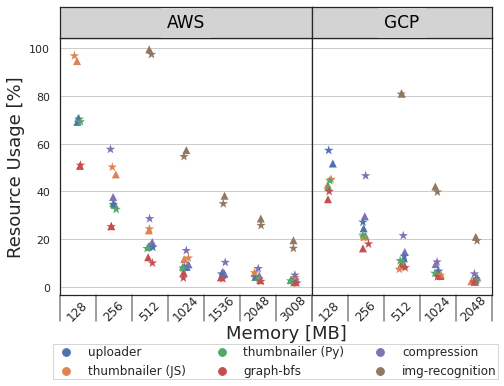

In [7]:
%matplotlib inline
import json
import os
import pandas as pd
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby

SAMPLES=200
plt.clf()

from matplotlib import gridspec

axs = []
f = plt.figure()


#sns.set(rc={'figure.figsize':(9, 5)})
sns.set(rc={'figure.figsize':(10, 4)})
sns.set(style="ticks")
sns.set_style("white")                                                                              
plt.rcParams["axes.grid"] = True                                                                    
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['pdf.fonttype'] = 42

def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

def cost_processing_aws(benchmark: str, group_name, df):

    time_original = d['provider_time']/1000
    time_roundup = (d['provider_time']/1000).apply(roundup)
    time_ratio = (time_original / time_roundup * 100).rename('time_ratio')

    mem = d['mem_used'] * 100.0
    mem /= group_name[0]
    mem.rename('mem_ratio')

    # combined ratio
    usage_ratio = (mem * time_ratio / 100.0).rename('usage_ratio')

    return [x.reset_index(drop=True) for x in [time_ratio, mem, usage_ratio]]

def cost_processing_gcp(benchmark: str, group_name, df):
    
    time_original = d['provider_time']/1000
    time_roundup = (d['provider_time']/1000).apply(roundup)
    time_ratio = (time_original / time_roundup * 100).rename('time_ratio')
   
    mem = []
    with open(os.path.join(
        os.path.pardir, os.path.pardir, os.path.pardir, "data", "performance",
        "gcp_perf_cost", benchmark, "perf-cost/",f"{group_name[1]}_results_{group_name[0]}-processed.json"
    )) as in_f:
        data = json.load(in_f)
        #print(data["_metrics"])
        sum_ = 0
        count = 0
        for mem_metric in next(iter(data["_metrics"].values()))['user_memory_bytes']:
            sum_ += (mem_metric['mean_value'] / 1024.0 / 1024.0)*mem_metric['executions_count']
            count += mem_metric['executions_count']
        mem = sum_/count

    mem_ratio = mem/group_name[0]*100.0
    mem = pd.Series([mem_ratio]).repeat(df.shape[0]).rename('mem_ratio')

    # combined ratio
    usage_ratio = (mem_ratio * time_ratio / 100.0).rename('usage_ratio')
    
    return [x.reset_index(drop=True) for x in [time_ratio, mem, usage_ratio]]

def add_line(ax, xpos, ypos,h=.1):
    line = plt.Line2D([xpos, xpos], [ypos + h, ypos],
                      transform=ax.transAxes, color='gray')
    line.set_clip_on(False)
    ax.add_line(line)

def label_len(my_index,level):
    labels = my_index.get_level_values(level)
    return [(k, sum(1 for i in g)) for k,g in groupby(labels)]

def label_group_bar_table(ax, df, rpositions):
    ypos = -.1
    scale = 1./df.index.get_level_values(0).nunique()#df.index.size
    for level in range(df.index.nlevels)[::-1]:
        pos = 0
        print(label_len(df.index,level))
        for label, rpos in label_len(df.index,level):
            #rpos = 1600
            rpos=1
            lxpos = (pos + .5 * rpos)*scale

            # lower for a longer text
            ypos_offset = 0
            if len(str(label)) > 6:
                ypos_offset = -.05
            ax.text(lxpos, ypos + ypos_offset, label, ha='center', transform=ax.transAxes, rotation=45)
            # but line always of the same height
            add_line(ax, pos*scale, ypos)
            pos += rpos
        add_line(ax, pos*scale , ypos)
        ypos -= .1

dirs = ['120', '210_python','210_node', '311', '411', '503']
dataframes = []
for i in range(len(dirs)):

    dir = dirs[i]
    
    datapoints_per_plot = []
    for name, full_name, proc_func in [["aws", "AWS", cost_processing_aws],
                                       ["gcp", "GCP", cost_processing_gcp]]:

        df = pd.read_csv(os.path.join(
            os.path.pardir, os.path.pardir, os.path.pardir, "data", "performance",
            f"{name}_perf_cost/{dir}/perf-cost/result.csv"
        ))
        # Remove accidental errors if not caught earlier
        df = df.drop(df[(df.type == 'warm') & (df.is_cold == True)].index)
        df = df.drop(df[(df.type == 'cold') & (df.is_cold == False)].index)
        # Remove cURL setup times (handshake, SSL, etc.) from client time
        df['client_time'] = df['client_time'] - df['connection_time'] * 1000*1000
        # GCP time is incorrectly in ms
        if name == 'gcp':
            df['provider_time'] = df['provider_time'].multiply(1000)
        # incorrect data for GCP NodeJS)
        df = df.drop(df[df.provider_time == 0].index)
        df = df.drop(df[df.exec_time == 0].index)

        # for each invocation type, take first SAMPLES invocations
        groups = []
            
        # remember the number of different configurations per provider
        datapoints_per_plot.append(df['memory'].nunique())
        df_grouped = df.groupby(['memory', 'type'])
        for group_name, df_group in df_grouped:
            # take first 200 samples
            d = df_group.head(SAMPLES)
            # add invocation cost for 1M invocations
            resource_usage = proc_func(dir, group_name, d)
            groups.append(pd.concat([d.reset_index(drop=True), *resource_usage], axis=1))
            
            # drop column to prevent issues later
            if 'mem_used' in groups[-1].columns:
                groups[-1].drop(['mem_used'], axis=1, inplace=True)
            
        df = pd.concat(groups)
        df['provider'] = name
        df['benchmark'] = dir
        #print(df.head(5))
        dataframes.append(df)


gs0 = gridspec.GridSpec(1, 1, figure=f,hspace=0.35, wspace=0.1)
gs00 = gridspec.GridSpecFromSubplotSpec(1, sum(datapoints_per_plot), subplot_spec=gs0[0],wspace=0)
prefix_sum = [0]
for val in datapoints_per_plot:
    prefix_sum.append(prefix_sum[-1] + val)
ax1 = f.add_subplot(gs00[0:1,:prefix_sum[1]])
ax2 = f.add_subplot(gs00[0:1,prefix_sum[1]:prefix_sum[2]], sharey=ax1)
axs = [ax1, ax2]


df = pd.concat(dataframes)
df.drop(['exec_time', 'connection_time', 'client_time', 'provider_time', 'is_cold'], axis=1, inplace=True)
df = pd.melt(df,id_vars=['memory', 'type', 'benchmark', 'provider'], var_name='value_type', value_name='value')
df.reset_index(drop=True, inplace=True)
df = df.sort_values(['memory','benchmark'])

for idx, name in enumerate(['aws', 'gcp']):

    ax = axs[idx]
    df_slice = df.loc[
                     (df['provider'] == name) &
                     (df['value_type'] == 'usage_ratio')
    ]
    #print(df_slice.head(5))
    df2 = df_slice.groupby(['memory', 'benchmark', 'type']).median().unstack().reset_index()
    df2['execution_type'] = df2['memory']
    df2.set_index(['memory'], inplace=True)
    df2.columns = [' '.join(col).strip() for col in df2.columns.values]
    df2.columns = df2.columns.get_level_values(0)
    #print(df2.head(5))
    
    sns.stripplot(
        x="execution_type",
        y="value cold",
        hue="benchmark",
        data=df2,#df_slice.loc[df_slice['type'] == 'cold'],
        ax=ax,
        size=8,
        marker='^'
    )
    sns.stripplot(
        x="execution_type",
        y="value warm",
        hue="benchmark",
        data=df2,#df_slice.loc[df_slice['type'] == 'warm'],
        ax=ax,
        size=10,
        marker='*'
    )

    # add boxes with data type
    from matplotlib.offsetbox import AnchoredText
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("top", size="12%", pad=0)
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_facecolor('lightgray')
    at = AnchoredText(name.upper(), loc=10, frameon=False,
                      prop=dict(backgroundcolor='lightgray',
                                size=17, color='black'))
    cax.add_artist(at)

    ax.legend().set_visible(False)
    ax.set_xticklabels('')
    ax.set_xlabel('')
    ax.set_ylabel('')
    #ax.set_yscale('log')
    ax.tick_params(axis='x',length=0, which='both', left=False,bottom=False, top=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    
    if idx > 0:
        ax.tick_params(axis='y',length=0, which='both', left=False,bottom=False, top=False, labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    label_group_bar_table(ax, df_slice.set_index(['memory']), [])

ax1.text(0.9, -0.17, 'Memory [MB]', ha='center', transform=ax1.transAxes, fontsize=18)     
ax1.set_ylabel('Resource Usage [%]',fontsize=18)

handles, labels = ax1.get_legend_handles_labels()
new_labels = {
    '210_python': 'thumbnailer (Py)',
    '120':'uploader',
    '210_node':'thumbnailer (JS)',
    '503':'graph-bfs',
    '411':'img-recognition',
    '311':'compression'
}
ax1.legend(handles[0:6], [new_labels[l] for l in labels[0:6]],
           bbox_to_anchor=(-0.05, -0.35),
           fancybox=False,
           prop={'size': 12},
           loc='lower left',           
           borderpad=0.1,
           ncol=3)
#ax2.legend(handles[0:6], [new_labels[l] for l in labels[0:6]],
#           bbox_to_anchor=(1.95, 0.5),
#           fancybox=False,
#           prop={'size': 14},
#           loc='center right',
#           ncol=1,
#           borderpad=0.1
#          )

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.01, hspace=0)
#plt.tight_layout()
plt.savefig('cost_efficiency.pdf', bbox_inches='tight')